### Importing

In [1]:
import cv2
from matplotlib import pyplot as plt
import math
import mido
import numpy as np
import os
import random

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten, Reshape, TimeDistributed, BatchNormalization
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

tf.compat.v1.disable_eager_execution()

In [22]:
os.environ['THEANORC'] = "./gpu.theanorc"
os.environ['KERAS_BACKEND'] = "theano"
import theano


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\eller\anaconda3\envs\EstudoMusica\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Setting variables

In [19]:
#Generating random songs settings
GENERATE_ONLY = False
NUM_RAND_SONGS = 10

WRITE_HISTORY = True

#Network parameters
BATCH_SIZE = 350
DROPOUT_RATE = 0.1
LEARNIN_RATE = 0.001
MAX_LENGTH = 4
NUM_EPOCHS = 2000
NUM_OFFSETS = 1
PARAM_SIZE = 120
#Batchnorm momentoum
BN_M = 0.9

#Fix the random seed
np.random.seed(0)
random.seed(0)

### Utilities to save the model statistics and generated song

In [4]:
def save_config():
    """
    Save training configs.
    """
    with open('results/config.txt', 'w') as fout:
        fout.write(f'Learning rate: {LEARNIN_RATE} \n')
        fout.write(f'Batchnorm momentoum: {BN_M}f\n')
        fout.write(f'Batch size: {BATCH_SIZE} \n')
        fout.write(f'Offsets: {NUM_OFFSETS} \n')
        fout.write(f'Dropout rate: {DROPOUT_RATE} \n')
        fout.write(f'Number of songs: {num_songs} \n')
        fout.write(f'optimizer: {type(model.optimizer).__name__} \n')

In [5]:
def plotScores(scores, fname, on_top=True):
    """
    Plot model loss.
    """
    plt.clf()
    ax = plt.gca()
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.yaxis.grid(True)
    plt.plot(scores)
    plt.ylim([0.0, 0.009])
    plt.xlabel('Epoch')
    plt.draw()
    plt.savefig(fname)

In [6]:
def make_rand_songs(write_dir, rand_vecs):
    for i in range(rand_vecs.shape[0]):
        x_rand = rand_vecs[i:i + 1] # x_rand.shape (1, Param_size)
        y_song = func([x_rand, 0])[0] # y_song.shape (1, compasso, tempo por toque, numero de notas)(1, 4, 16, 128)
        samples_to_midi(y_song[0], write_dir + 'rand' + str(i) + '.mid', 16, 0.25)
    
def make_rand_songs_normalized(write_dir, rand_vecs):
    x_enc = np.squeeze(model_encoder.predict(y_orig)) # x_enc.shape (num_songs, Param_size)
    x_mean = np.mean(x_enc, axis=0) # x_mean.shape (Param_size)
    x_stds = np.std(x_enc, axis=0) # x_stds.shape (Param_size)
    x_cov = np.cov((x_enc - x_mean).T) # x_cov.shape (Param_size,Param_size)
    _, s, v = np.linalg.svd(x_cov)
    e = np.sqrt(s)

#     print("Means: ", x_mean[:6])
#     print("Evals: ", e[:6])

    np.save(write_dir + 'means.npy', x_mean)
    np.save(write_dir + 'stds.npy', x_stds)
    np.save(write_dir + 'evals.npy', e)
    np.save(write_dir + 'evecs.npy', v)

    x_vecs = x_mean + np.dot(rand_vecs * e, v) # x_vecs.shape (numRandSongs, Param_size)
#     print(x_vecs.shape) 
#     print(x_mean.shape)
    make_rand_songs(write_dir, x_vecs)

    title = '' 
    if '/' in write_dir:
        title = 'Epoch: ' + write_dir.split('/')[-2][1:]

    plt.clf()
    e[::-1].sort()
    plt.title(title)
    plt.bar(np.arange(e.shape[0]), e, align='center')
    plt.draw()
    plt.savefig(write_dir + 'evals.png')

    plt.clf()
    plt.title(title)
    plt.bar(np.arange(e.shape[0]), x_mean, align='center')
    plt.draw()
    plt.savefig(write_dir + 'means.png')

    plt.clf()
    plt.title(title)
    plt.bar(np.arange(e.shape[0]), x_stds, align='center')
    plt.draw()
    plt.savefig(write_dir + 'stds.png')

In [7]:
# #Util to use img .png
# def sample_to_pic(fname, sample, thresh=None):
#     if thresh is not None:
#         inverted = np.where(sample > thresh, 0, 1)
#     else:
#         inverted = 1.0 - sample
#     cv2.imwrite(fname, inverted * 255)

# def samples_to_pics(dir, samples, thresh=None):
#     if not os.path.exists(dir): 
#         os.makedirs(dir)
#     for i in range(samples.shape[0]):
#         sample_to_pic(dir + '/s' + str(i) + '.png', samples[i], thresh)

In [8]:
def samples_to_midi(samples, fname, SPM, thresh=0.5):
    """
    Turn samples into midi. Reagroup samples into a measure.
    :param samples: List of samples that will be jointed (dtype=np.uint8)
    :param fname: Midi file name that will be used
    :param SPM: Samples per measured int the mid file 
    :param thresh: the higher the treshold the less notes will come out of the song
    :return:
    """
    #Creates mid object and adding track to it
    mid = mido.MidiFile()
    track = mido.MidiTrack()
    mid.tracks.append(track)

    TPM = 4 * mid.ticks_per_beat #Get ticks per measure
    ticks_per_sample = int(TPM / SPM)
    
    #Its possible to add types of instruments but i wont do it in this version fell free to add it
    #en.wikipedia.org/wiki/General_MIDI#Program_change_events

    abs_time = 0
    last_time = 0

    for sample in samples:
        
        for y in range(sample.shape[0]):
            abs_time += ticks_per_sample*4
            
            for x in range(sample.shape[1]):
                note = int(x)

                ####### It needs an upgrade #######
                # velocity = int(sample[y,x]*127)
                
                if sample[y,x] >= thresh and (y == 0 or sample[y - 1, x] < thresh):
                    delta_time = abs_time - last_time
                    track.append(mido.Message('note_on', note=note, velocity= 127, time= delta_time))
                    last_time = abs_time
                
                if sample[y,x] >= thresh and (y == sample.shape[0] - 1 or sample[y + 1, x] < thresh):
                    delta_time = abs_time - last_time
                    track.append(mido.Message('note_off', note=note, velocity= 127, time=delta_time))
                    last_time = abs_time
                    
    return mid.save(fname)

### Model

In [9]:
# Create folders to save models into
if not os.path.exists('results'):
    os.makedirs('results')
if WRITE_HISTORY and not os.path.exists('results/history'):
    os.makedirs('results/history')

In [10]:
#Checking if there is data and loading it 
print("\nLoading Data...")
try:
    y_samples = np.load("samples.npy")
    print("samples loded")
    y_lengths = np.load("lengths.npy")
    print("lengths loded")
except:
    raise FileNotFoundError("No data found, try to check if you have a input dataset, and run four2fourTimeSignature.ipynb again!")


Loading Data...
samples loded
lengths loded


In [11]:
#Sets the number of samples, already printed in load_songs.py
num_samples = y_samples.shape[0]
num_songs = y_lengths.shape[0]

print(f"Loaded {num_samples} samples from {num_songs} songs.\n")
assert(np.sum(y_lengths) == num_samples)

x_shape = (num_songs * NUM_OFFSETS, 1) 
x_orig = np.expand_dims(np.arange(x_shape[0]), axis=-1) 

# y_shape = (num of songs, max num of window, num of pithc per window, num of notes)
y_shape = (num_songs * NUM_OFFSETS, MAX_LENGTH) + y_samples.shape[1:] #This case (n, 4, 16, 128)
y_orig = np.zeros(y_shape, dtype=y_samples.dtype) #Prepare dataset array

Loaded 616886 samples from 3920 songs.



In [12]:
## fill in measure of songs into input windows for network
# Song start index
SSix = 0
# Song end index
SEix = 0

for song_ix in range(num_songs):
    for offset in range(NUM_OFFSETS):
        ix = song_ix * NUM_OFFSETS + offset # calculate the index of the song with its offset
        SEix = SSix + y_lengths[song_ix] 
        
        for window_ix in range(MAX_LENGTH):
            size = (window_ix + offset) % (SEix - SSix)  # chosen measure of song to be placed in window (modulo song length)
            y_orig[ix,window_ix] = y_samples[SSix + size] # move measure into window
    SSix = SEix

x_train = np.copy(x_orig)
y_train = np.copy(y_orig)

In [13]:
# copy some song from the samples and write it to midi again
test_ix = 0
y_test_song = np.copy(y_train[test_ix: test_ix + 1])
x_test_song = np.copy(x_train[test_ix: test_ix + 1])
samples_to_midi(y_test_song[0], 'gt.mid', 16)

In [14]:
rand_vecs = np.random.normal(0.0, 1.0, (NUM_RAND_SONGS, PARAM_SIZE))
np.save('rand.npy', rand_vecs)

In [15]:
###################################
#  Create Model
###################################
print("Building Model...")
model_encoder = Sequential([
    Input(shape=y_shape[1:]),
    Reshape((y_shape[1], -1)),
    TimeDistributed(Dense(2000, activation='relu')),
    TimeDistributed(Dense(200, activation='relu')),
    Flatten(),
    Dense(1600, activation='relu'),
    Dense(PARAM_SIZE),
    BatchNormalization(momentum=BN_M, name='pre_encoder'),
])

model_decoder = Sequential([
    Input(shape=(PARAM_SIZE,)),
    Dense(1600, name='encoder'),
    BatchNormalization(momentum=BN_M),
    Activation('relu'),
    Dropout(DROPOUT_RATE),
    Dense(MAX_LENGTH * 200),
    Reshape((MAX_LENGTH, 200)),
    TimeDistributed(BatchNormalization(momentum=BN_M)),
    Activation('relu'),
    Dropout(DROPOUT_RATE),
    TimeDistributed(Dense(2000)),
    TimeDistributed(BatchNormalization(momentum=BN_M)),
    Activation('relu'),
    Dropout(DROPOUT_RATE),
    TimeDistributed(Dense(y_shape[2] * y_shape[3], activation='sigmoid')),
    Reshape((y_shape[1], y_shape[2], y_shape[3])),
])

model = Sequential([
    model_encoder,
    model_decoder,
])

model.compile(optimizer=RMSprop(lr=LEARNIN_RATE), loss='binary_crossentropy')

Building Model...


In [16]:
# model.summary()

In [17]:
print("Compiling SubModels...")
func = K.function([model_decoder.input, K.learning_phase()],
                  [model_decoder.output])

Compiling SubModels...



Training...
Train on 3920 samples
3920/3920 [==============================] - 1s 164us/sample - loss: 0.0030

Train Loss: 0.0030091327041321036

Saved
Train on 3920 samples
3920/3920 [==============================] - 1s 148us/sample - loss: 0.0029

Train Loss: 0.0028771775541827083
Train on 3920 samples
3920/3920 [==============================] - 1s 150us/sample - loss: 0.0028

Train Loss: 0.002788204624916294
Train on 3920 samples
3920/3920 [==============================] - 1s 155us/sample - loss: 0.0027

Train Loss: 0.002733106030583648
Train on 3920 samples
3920/3920 [==============================] - 1s 159us/sample - loss: 0.0024

Train Loss: 0.0024455843293773277
Train on 3920 samples
3920/3920 [==============================] - 1s 164us/sample - loss: 0.0022

Train Loss: 0.002248040452416587
Train on 3920 samples
3920/3920 [==============================] - 1s 175us/sample - loss: 0.0022

Train Loss: 0.0022490175927357215
Train on 3920 samples
3920/3920 [===================

3920/3920 [==============================] - 1s 143us/sample - loss: 9.2147e-04

Train Loss: 0.000921472000689911
Train on 3920 samples
3920/3920 [==============================] - 1s 145us/sample - loss: 9.2937e-04

Train Loss: 0.0009293678366313023
Train on 3920 samples
3920/3920 [==============================] - 1s 142us/sample - loss: 9.5578e-04

Train Loss: 0.0009557825854114656
Train on 3920 samples
3920/3920 [==============================] - 1s 142us/sample - loss: 9.6558e-04

Train Loss: 0.0009655834396003879
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 9.6237e-04

Train Loss: 0.0009623699692643381
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 9.9564e-04

Train Loss: 0.0009956446842157415
Train on 3920 samples
3920/3920 [==============================] - 1s 146us/sample - loss: 9.4781e-04

Train Loss: 0.0009478052067736696
Train on 3920 samples
3920/3920 [==============================]

Train on 3920 samples
3920/3920 [==============================] - 1s 142us/sample - loss: 7.6231e-04

Train Loss: 0.0007623131334964585
Train on 3920 samples
3920/3920 [==============================] - 1s 144us/sample - loss: 7.5285e-04

Train Loss: 0.0007528458195987955
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 7.6588e-04

Train Loss: 0.0007658781593948204
Train on 3920 samples
3920/3920 [==============================] - 1s 142us/sample - loss: 7.4943e-04

Train Loss: 0.0007494304112956993
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 7.6315e-04

Train Loss: 0.0007631489508120077
Train on 3920 samples
3920/3920 [==============================] - 1s 142us/sample - loss: 7.6708e-04

Train Loss: 0.0007670781051274389
Train on 3920 samples
3920/3920 [==============================] - 1s 148us/sample - loss: 7.4456e-04

Train Loss: 0.0007445633912409123
Train on 3920 samples
3920/3920 [========

Train on 3920 samples
3920/3920 [==============================] - 1s 144us/sample - loss: 6.1785e-04

Train Loss: 0.0006178510115465283
Train on 3920 samples
3920/3920 [==============================] - 1s 144us/sample - loss: 6.2673e-04

Train Loss: 0.0006267342993981272
Train on 3920 samples
3920/3920 [==============================] - 1s 146us/sample - loss: 6.3455e-04

Train Loss: 0.0006345527539711579
Train on 3920 samples
3920/3920 [==============================] - 1s 145us/sample - loss: 6.4560e-04

Train Loss: 0.0006456004869375777
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 7.0292e-04

Train Loss: 0.00070291683160966
Train on 3920 samples
3920/3920 [==============================] - 1s 145us/sample - loss: 7.0271e-04

Train Loss: 0.0007027102635350145
Train on 3920 samples
3920/3920 [==============================] - 1s 146us/sample - loss: 6.9792e-04

Train Loss: 0.0006979180730663107
Train on 3920 samples
3920/3920 [==========

Train on 3920 samples
3920/3920 [==============================] - 1s 145us/sample - loss: 5.8536e-04

Train Loss: 0.0005853639777342323
Train on 3920 samples
3920/3920 [==============================] - 1s 144us/sample - loss: 6.0938e-04

Train Loss: 0.0006093837037042249
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 5.8754e-04

Train Loss: 0.00058753999993704
Train on 3920 samples
3920/3920 [==============================] - 1s 144us/sample - loss: 6.0399e-04

Train Loss: 0.0006039904281871193
Train on 3920 samples
3920/3920 [==============================] - 1s 142us/sample - loss: 6.1667e-04

Train Loss: 0.0006166745494868207
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 6.2327e-04

Train Loss: 0.0006232722885865119
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 6.3161e-04

Train Loss: 0.0006316060659758348
Train on 3920 samples
3920/3920 [==========


Train Loss: 0.0005054166057172031
Train on 3920 samples
3920/3920 [==============================] - 1s 155us/sample - loss: 4.9762e-04

Train Loss: 0.0004976248263639198
Train on 3920 samples
3920/3920 [==============================] - 1s 146us/sample - loss: 4.9663e-04

Train Loss: 0.0004966315885082752
Train on 3920 samples
3920/3920 [==============================] - 1s 145us/sample - loss: 5.0208e-04

Train Loss: 0.000502083266578016
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 4.8659e-04

Train Loss: 0.00048658965689745467
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 4.8586e-04

Train Loss: 0.0004858553693338763
Train on 3920 samples
3920/3920 [==============================] - 1s 146us/sample - loss: 5.1055e-04

Train Loss: 0.0005105473641638777
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 4.9593e-04

Train Loss: 0.0004959314225873511
Train 

3920/3920 [==============================] - 1s 146us/sample - loss: 5.0840e-04

Train Loss: 0.0005083959227444471
Train on 3920 samples
3920/3920 [==============================] - 1s 148us/sample - loss: 4.9812e-04

Train Loss: 0.0004981226032084253
Train on 3920 samples
3920/3920 [==============================] - 1s 150us/sample - loss: 5.0222e-04

Train Loss: 0.0005022246540257973
Train on 3920 samples
3920/3920 [==============================] - 1s 147us/sample - loss: 5.0896e-04

Train Loss: 0.0005089564723935577
Train on 3920 samples
3920/3920 [==============================] - 1s 147us/sample - loss: 4.7656e-04

Train Loss: 0.0004765649136970751
Train on 3920 samples
3920/3920 [==============================] - 1s 148us/sample - loss: 4.7763e-04

Train Loss: 0.0004776266073999328
Train on 3920 samples
3920/3920 [==============================] - 1s 148us/sample - loss: 4.7823e-04

Train Loss: 0.00047823214429497184
Train on 3920 samples
3920/3920 [=============================

Train on 3920 samples
3920/3920 [==============================] - 1s 144us/sample - loss: 4.1448e-04

Train Loss: 0.0004144807535340078
Train on 3920 samples
3920/3920 [==============================] - 1s 143us/sample - loss: 4.1475e-04

Train Loss: 0.0004147475525054948
Train on 3920 samples
3920/3920 [==============================] - 1s 151us/sample - loss: 4.2523e-04

Train Loss: 0.0004252280435009327
Train on 3920 samples
3920/3920 [==============================] - 1s 148us/sample - loss: 4.2438e-04

Train Loss: 0.00042438178830447474
Train on 3920 samples
3920/3920 [==============================] - 1s 148us/sample - loss: 4.2513e-04

Train Loss: 0.0004251266727806069
Train on 3920 samples
3920/3920 [==============================] - 1s 144us/sample - loss: 4.1374e-04

Train Loss: 0.00041374081878789833
Train on 3920 samples
3920/3920 [==============================] - 1s 146us/sample - loss: 4.0754e-04

Train Loss: 0.00040753996498616677
Train on 3920 samples
3920/3920 [=====


Train Loss: 0.0004581534189388289
Train on 3920 samples
3920/3920 [==============================] - 1s 149us/sample - loss: 4.5342e-04

Train Loss: 0.00045341858068630766
Train on 3920 samples
3920/3920 [==============================] - 1s 146us/sample - loss: 4.5776e-04

Train Loss: 0.0004577641427333999
Train on 3920 samples
3920/3920 [==============================] - 1s 145us/sample - loss: 4.5853e-04

Train Loss: 0.00045852567148228573
Train on 3920 samples
3920/3920 [==============================] - 1s 145us/sample - loss: 4.7461e-04

Train Loss: 0.0004746100748889148
Train on 3920 samples
3920/3920 [==============================] - 1s 146us/sample - loss: 4.6486e-04

Train Loss: 0.0004648581769807996
Train on 3920 samples
3920/3920 [==============================] - 1s 144us/sample - loss: 4.7400e-04

Train Loss: 0.0004740018495275373
Train on 3920 samples
3920/3920 [==============================] - 1s 147us/sample - loss: 4.7806e-04

Train Loss: 0.0004780562194355298
Trai

3920/3920 [==============================] - 1s 153us/sample - loss: 4.1673e-04

Train Loss: 0.0004167304697537994
Train on 3920 samples
3920/3920 [==============================] - 1s 157us/sample - loss: 4.0904e-04

Train Loss: 0.0004090441387753734
Train on 3920 samples
3920/3920 [==============================] - 1s 160us/sample - loss: 4.0027e-04

Train Loss: 0.00040026641831250994
Train on 3920 samples
3920/3920 [==============================] - 1s 158us/sample - loss: 3.8262e-04

Train Loss: 0.0003826176933736341
Train on 3920 samples
3920/3920 [==============================] - 1s 149us/sample - loss: 3.8656e-04

Train Loss: 0.0003865604241062621
Train on 3920 samples
3920/3920 [==============================] - 1s 148us/sample - loss: 4.0315e-04

Train Loss: 0.00040315038391522
Train on 3920 samples
3920/3920 [==============================] - 1s 146us/sample - loss: 4.1746e-04

Train Loss: 0.0004174585813286415
Train on 3920 samples
3920/3920 [==============================]

KeyboardInterrupt: 

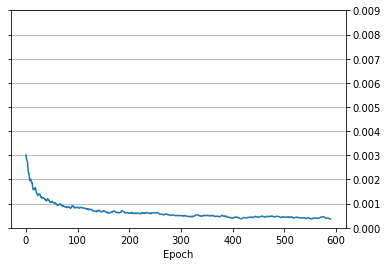

In [20]:
if GENERATE_ONLY:
    print("\nGenerating Songs...")
    make_rand_songs_normalized('', rand_vecs)
    for i in range(20):
        x_test_song = x_train[i:i+1]
        y_song = model.predict(x_test_song, batch_size=BATCH_SIZE)[0]
        samples_to_midi(y_song, 'gt' + str(i) + '.mid', 16)
    exit(0)
          
print("\nTraining...")
save_config()
train_loss = []
ofs = 0

for iteration in range(NUM_EPOCHS):
    cur_ix = 0
    for i in range(num_songs):
        end_ix = cur_ix + y_lengths[i]
        for j in range(MAX_LENGTH):
            k = (j + ofs) % (end_ix - cur_ix)
            y_train[i,j] = y_samples[cur_ix + k]
        cur_ix = end_ix
    assert(end_ix == num_samples)
    ofs += 1

    history = model.fit(y_train, y_train, batch_size=BATCH_SIZE, epochs=1)

    loss = history.history["loss"][-1]
    train_loss.append(loss)
    print("\nTrain Loss: " + str(train_loss[-1]))
    
    if WRITE_HISTORY:
        plotScores(train_loss, 'results/history/Scores.png', True)
    else:
        plotScores(train_loss, 'Scores.png', True)
    
    i = iteration + 1
    if i in [1, 10, 100, 300, 350, 400, 700] or (i % 1000 == 0):
        write_dir = ''
        if WRITE_HISTORY:
            #Create folder to save models into
            write_dir = 'results/history/e' + str(i)
            if not os.path.exists(write_dir):
                os.makedirs(write_dir)
            write_dir += '/'
            model.save('results/history/model.h5')
        else:
            model.save('model.h5')
        print("\nSaved")

        y_song = model.predict(y_test_song, batch_size=BATCH_SIZE)[0]
#         samples_to_pics(write_dir + 'test', y_song)
        samples_to_midi(y_song, write_dir + 'test.mid', 16)
        
        make_rand_songs_normalized(write_dir, rand_vecs)


print("\nDone")
